<a href="https://colab.research.google.com/github/BobGanti/ColabNotebooks/blob/main/ECRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation For CRAG <br>(Corrective Retrieval Augmentation Generation)

### Required Libraries

### Mounting the drive and setting up the environment variables (Colab specific)

In [1]:
!pip install -q \
torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pyarrow==14.0.1 datasets==2.13.0 \
dill \
openai \
requests \
datasets \
accelerate \
beautifulsoup4 \
PyPDF2 PyMuPDF \
faiss-cpu faiss-gpu \
google-api-python-client \
transformers sentence-transformers sentencepiece rank-bm25


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102

In [2]:
import os
import re
import torch
import dill as pickle
import uuid
import numpy as np
import openai
from openai import OpenAI
from torch.utils.data import Dataset
import transformers
import faiss
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
import pymupdf
import nltk
from nltk import sent_tokenize


In [3]:
# Mounting the Google Drive
from google.colab import drive, userdata
drive = drive.mount('/content/drive', force_remount=True)

# Environment Variables SetUp
DATA_DIR = userdata.get('ROOT_DIR')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
GOOGLE_SEARCH_API_KEY = userdata.get('GOOGLE_SEARCH_API_KEY')
GOOGLE_CSE_ID = userdata.get('GOOGLE_CSE_ID')
arxiv_DIR = DATA_DIR + "/arxiv"
PDF_DIR = arxiv_DIR + "/PDFs"


Mounted at /content/drive


# Smarter CRAG (SCRAG)

In [4]:

# from transformers import AutoTokenizer, AutoModel
# from nltk.tokenize import sent_tokenize

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:

global_document_counter = 0
global_chunk_counter = 0
global_subchunk_counter = 0

class Subchunk:
    def __init__(self, metadata, text, subchunk_embedding):
        self.metadata = metadata
        self.text = text
        self.subchunk_embedding = subchunk_embedding

    def __repr__(self):
        return f"Subchunk(Global Subchunk: {self.metadata['global_subchunk_number']}, Subchunk ID: {self.metadata['subchunk_id']}, Parent Chunk: {self.metadata['chunk_id']})"


class SmartChunk:
    def __init__(self, metadata, text, chunksummary, chunksummary_embedding):
        self.text = text
        self.metadata = metadata
        self.chunksummary = chunksummary
        self.chunksummary_embedding = chunksummary_embedding
        self.subchunks = []

    def add_subchunk(self, subchunks):
        self.subchunks.extend(subchunks)

    def __repr__(self):
        return f"Chunk(Global Chunk number: {self.metadata['global_chunk_number']}, Chunk ID: {self.metadata['chunk_id']}, Title: {self.metadata['title']}, Page: {self.metadata['page_number']})"


class SmartDocument:
    def __init__(self, path, max_chunk_size=2500, min_chunk_size=300, chunk_overlap=100, subchunk_size=300, subchunk_overlap=50):
        global global_document_counter
        self.path = path
        self.title = os.path.splitext(os.path.basename(path))[0]
        self.document_id = f"{self.title.replace(' ', '_')}#{str(uuid.uuid4())[:10]}"
        self.max_chunk_size = max_chunk_size
        self.min_chunk_size = min_chunk_size
        self.chunk_overlap = chunk_overlap
        self.subchunk_size = subchunk_size
        self.subchunk_overlap = subchunk_overlap
        self.chunks = []

        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=-1)
        self.embedding_model = EmbeddingModel()
        self._process_document()

    def __getstate__(self):
        # Exclude non-pickleable attributes
        state = self.__dict__.copy()
        state['summarizer'] = None
        state['embedding_model'] = None
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        device = 0 if torch.cuda.is_available() else -1
        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=device)
        self.embedding_model = EmbeddingModel()

    def _process_document(self):
        global global_chunk_counter
        document = pymupdf.open(self.path)
        num_chunks = 0
        print(f"\nProcessing document: {self.title}")
        print(f"Number of pages: {len(document)}")

        # Variable to hold a small chunk to merge with the next one
        small_chunk_to_merge = None

        for num in range(len(document)):
            page = document.load_page(num)
            page_text = self._get_clean_page_text(page)
            page_chunks = self._custom_chunk_text(page_text, self.max_chunk_size, self.chunk_overlap)

            for chunk in page_chunks:
                # If we have a small chunk to merge, merge it with the current chunk
                if small_chunk_to_merge:
                    chunk = small_chunk_to_merge + " " + chunk
                    small_chunk_to_merge = None  # Reset the variable after merging

                # Check if the current chunk is too small
                if len(chunk) < self.min_chunk_size:
                    # If there are already chunks in self.chunks, merge with the last one
                    if len(self.chunks) > 0:
                        print("Chars before: ", len(self.chunks[-1].text))
                        self.chunks[-1].text += "\n" + chunk  # Access the last appended chunk
                        self.chunks[-1].chunksummary += "\n" + self._summarise_chunk(chunk)
                        print("Chars after: ", len(self.chunks[-1].text))
                        continue
                    else:
                        # If no previous chunk, hold this small chunk to merge with the next one
                        small_chunk_to_merge = chunk
                        print(f"Holding small chunk to merge with next: Pge-{num + 1}-Chnk{num_chunks + 1}")
                        continue

                else:

                    # If the chunk is valid, process it as normal
                    try:
                        chunksummary = self._summarise_chunk(chunk)
                        chunksummary_embedding = self.embedding_model.get_embedding(chunksummary)

                        num_chunks += 1
                        global_chunk_counter += 1
                        page_number = num + 1

                        metadata = {
                            "title": self.title,
                            "document_id": self.document_id,
                            "page_number": page_number,
                            "chunk_id": f"Pge-{page_number}-Chnk{num_chunks}",
                            "chunk_number": num_chunks,
                            "global_chunk_number": global_chunk_counter,
                        }

                        chunk_obj = SmartChunk(metadata, chunk, chunksummary, chunksummary_embedding)
                        chunk_obj.subchunks = self._create_subchunks(chunk_obj)

                        self.chunks.append(chunk_obj)
                        print(f"Added chunk {chunk_obj.metadata}")
                    except Exception as e:
                        print(f"Error processing chunk on page {num}: {e}")
                        continue


    def _get_clean_page_text(self, page):
        text = page.get_text()
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
        text = self._remove_references(text)
        return text

    def _remove_references(self, text):
        # Heuristic to remove the References section in the PDF file
        text = re.split(r'References|Bibliography', text, flags=re.IGNORECASE)[0]
        return text

    def _custom_chunk_text(self, text, max_chunk_size, chunk_overlap):
        chunks = []
        sentences = sent_tokenize(text)
        current_chunk = []
        current_chunk_size = 0

        for sentence in sentences:
            sentence_length = len(sentence)

            if current_chunk_size + sentence_length > max_chunk_size:
                chunks.append(' '.join(current_chunk).strip())
                current_chunk = [sentence]
                current_chunk_size = sentence_length
            else:
                current_chunk.append(sentence)
                current_chunk_size += sentence_length

        if current_chunk:
            chunks.append(' '.join(current_chunk).strip())
        return chunks

    def _summarise_chunk(self, chunk):
        chunk_length = len(chunk)

        # If the chunk is too small, return the chunk itself as the summary
        if chunk_length <= self.min_chunk_size:
            return chunk
        else:
            summary_text = self._generate_summary(chunk, chunk_length)

            # Ensure the summarizer output is not empty
            if not summary_text or len(summary_text.strip()) == 0:
                print("Chunk too small, using chunk as summary.")
                return chunk

            return summary_text

    def _generate_summary(self, chunk, chunk_length):
        summary_max_length = int(0.50 * chunk_length)
        summary_min_length = int(0.20 * chunk_length)

        max_length = summary_max_length // 4  # Estimation for the max token value
        min_length = summary_min_length // 4  # Estimation for the min token value

        summary = self.summarizer(
            chunk,
            max_length=max_length,
            min_length=min_length,
            do_sample=False
        )
        summary_text = summary[0]['summary_text']
        return summary_text

    def _create_subchunks(self, chunk_obj):
        global global_subchunk_counter
        subchunks = []
        chunk_text = chunk_obj.text
        sentences = sent_tokenize(chunk_text)
        current_subchunk = []
        current_subchunk_size = 0
        subchunk_number = 0

        for sentence in sentences:
            sentence_length = len(sentence)

            if current_subchunk_size + sentence_length > self.subchunk_size:
                # Create and append subchunk when the size limit is exceeded
                subchunk_text = ' '.join(current_subchunk).strip()

                if not subchunk_text or len(subchunk_text.strip()) == 0:
                    subchunk_text = chunk_obj.text
                    print("Chunk too small for subchunking, using chunk as subchunk.")

                # Create metadata and append subchunk
                subchunk_metadata = {
                    "chunk_id": chunk_obj.metadata['chunk_id'],
                    "subchunk_id": f"{chunk_obj.metadata['chunk_id']}-Sub{len(subchunks) + 1}",
                    "subchunk_number": subchunk_number + 1,
                    "global_subchunk_number": global_subchunk_counter + 1,  # Increment only for valid subchunks
                }
                subchunk_embedding = self.embedding_model.get_embedding(subchunk_text)
                subchunk = Subchunk(subchunk_metadata, subchunk_text, subchunk_embedding)

                subchunks.append(subchunk)
                print("     Subchunk: ", subchunk.metadata)

                subchunk_number += 1
                global_subchunk_counter += 1

                # Reset current subchunk
                current_subchunk = [sentence]
                current_subchunk_size = sentence_length
            else:
                # Continue building the current subchunk
                current_subchunk.append(sentence)
                current_subchunk_size += sentence_length

        return subchunks


    def save_document(self, dir_path):
        os.makedirs(dir_path, exist_ok=True)
        file_path = os.path.join(dir_path, f'{self.document_id}.pkl')
        with open(file_path, 'wb') as file:
            pickle.dump(self, file)

    @staticmethod
    def load_document(file_path):
        with open(file_path, 'rb') as file:
            return pickle.load(file)

    def __repr__(self):
        return f"SmartDocument({self.title}, {len(self.chunks)} chunks)"

class EmbeddingModel:
    def __init__(self):
        openai.api_key = OPENAI_API_KEY
        self.client = OpenAI(api_key=openai.api_key)
        self.model = "text-embedding-3-small"

    def get_embedding(self, text):
        MAX_TOKEN_LIMIT = 8191
        if not isinstance(text, str) or len(text.strip()) == 0:
            print("Invalid input for embedding: Empty or non-string.")
            return None

        # Truncate the text if it's too long for the model
        if len(text) > MAX_TOKEN_LIMIT:
            print(f"Text is too long for embedding {MAX_TOKEN_LIMIT} tokens), truncating...")
            text = text[:MAX_TOKEN_LIMIT]

        try:
            response = self.client.embeddings.create(
                input=[text],
                model=self.model
            )
            embedding = response.data[0].embedding
            return embedding
        except Exception as e:
            print(f"Error generating embedding: {e}")
            return None

    def get_embeddings(self, texts):
        embeddings = []
        for text in texts:
            embedding = self.get_embedding(text)
            embeddings.append(embedding)
        return embeddings

# FAISS Vectorstore class without redundant reshaping
class FAISSVectorstore:
    def __init__(self, embedding_dimension):
        self.embedding_dimension = embedding_dimension
        self.chunk_index = faiss.IndexFlatL2(embedding_dimension)
        self.loaded_chunks = []

    def add_chunk_embedding(self, embedding, chunk):
        """Add a chunk embedding and store the corresponding chunk."""
        self.chunk_index.add(embedding)
        self.loaded_chunks.append(chunk)

    def save_index_and_chunks(self, index_filepath, chunks_filepath):
        """Save FAISS chunk index and corresponding chunks."""
        # Save FAISS chunk index
        faiss.write_index(self.chunk_index, index_filepath)
        print(f"FAISS chunk index saved at: {index_filepath}")

        # Save chunks
        with open(chunks_filepath, 'wb') as f:
            pickle.dump(self.loaded_chunks, f)
        print(f"Chunks saved at: {chunks_filepath}")

    def load_index_and_chunks(self, index_filepath, chunks_filepath):
        """Load FAISS chunk index and corresponding chunks."""
        # Load FAISS chunk index
        self.chunk_index = faiss.read_index(index_filepath)
        print(f"FAISS chunk index loaded from: {index_filepath}")

        # Load chunks
        with open(chunks_filepath, 'rb') as f:
            self.loaded_chunks = pickle.load(f)
        print(f"Chunks loaded from: {chunks_filepath}")

    def search_chunks(self, query_embedding, k=5):
        """Search for the top_k most relevant chunk embeddings."""
        query_embedding = np.array(query_embedding).astype('float32').reshape(1, -1)
        distances, indices = self.chunk_index.search(query_embedding, top_k)
        return distances, indices

# Custom dataset class
class GPT2Dataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        return item

class EvaluatorEncoder:
    # Function to encode the data using the fine-tuned tokenizer
    def encode_data(self, tokenizer, data, max_length=512, is_test=False):
        inputs = tokenizer(
            [f"Question: {q} Context: {c}" for q, c in zip(data['Query'].tolist(), data['Chunk'].tolist())],
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )
        if not is_test:  # Only convert labels if not test data
            labels = torch.tensor(data['Relevance'].tolist())
            inputs['labels'] = labels
        return inputs


In [6]:
import os

pdf_dir = arxiv_DIR + '/PDFs'
doc_dir = arxiv_DIR + '/SmartDocuments'
os.makedirs(doc_dir, exist_ok=True)

In [ ]:
def load_documents(doc_dir):
    documents = []
    filenames = [filename for filename in os.listdir(doc_dir) if filename.endswith('.pkl')]
    for filename in filenames[:1]:
        #if filename.endswith('.pkl'):
        file_path = os.path.join(doc_dir, filename)
        document = SmartDocument.load_document(file_path)
        documents.append(document)
    return documents

# loaded_documents = load_documents(doc_dir)


In [ ]:
import os

def process_pdfs(pdf_dir, doc_dir):

    global global_chunk_counter
    global global_subchunk_counter
    if len(loaded_documents) > 0:
        global_chunk_counter = loaded_documents[-1].chunks[-1].metadata['global_chunk_number']
        global_subchunk_counter = loaded_documents[-1].chunks[-1].subchunks[-1].metadata['global_subchunk_number']

    documents = []
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]
    print(f"Found {len(pdf_files)} PDF files in the directory.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_dir, pdf_file)

        # Process the document
        document = SmartDocument(
            path=pdf_path,
            max_chunk_size=2500,
            min_chunk_size=300,
            chunk_overlap=100,
            subchunk_size=300,
            subchunk_overlap=50
        )
        documents.append(document)

        # Save the document
        document.save_document(doc_dir)
        print(f"Saved document: {document.title}")
    return documents

os.makedirs(doc_dir, exist_ok=True)
# documents = process_pdfs(pdf_dir, doc_dir)


In [7]:
# doc_dir = arxiv_DIR + '/SmartDocuments'
faiss_dir = arxiv_DIR + '/SmartFAISS'
os.makedirs(faiss_dir, exist_ok=True)

index_filepath = faiss_dir + "/chunk_faiss.index"
chunks_filepath = faiss_dir + "/loaded_chunks.pkl"


In [ ]:
def add_document_to_vectorstore(documents):
    for document in documents:
        for chunk in document.chunks:
            chunk_embedding = np.array(chunk.chunksummary_embedding).astype('float32').reshape(1, -1)
            faiss_store.add_chunk_embedding(chunk_embedding, chunk)

        print(f"Number of records in the FAISS index: {faiss_store.chunk_index.ntotal}")

    # Save the FAISS index and chunks
    faiss_store.save_index_and_chunks(index_filepath, chunks_filepath)

# add_document_to_vectorstore(documents)


## Frontend

### Initialise the Vectorstore

In [8]:

# Initialising the custom FAISSVectorstore
embedding_dimension = 1536
faiss_store = FAISSVectorstore(embedding_dimension)
faiss_store.load_index_and_chunks(index_filepath, chunks_filepath)

chunk_index = faiss_store.chunk_index
loaded_chunks = faiss_store.loaded_chunks
print("Total Index Records: ", chunk_index.ntotal)
print("Total Chunk Records: ", loaded_chunks.__len__())


FAISS chunk index loaded from: /content/drive/MyDrive/Datasets/arxiv/SmartFAISS/chunk_faiss.index
Chunks loaded from: /content/drive/MyDrive/Datasets/arxiv/SmartFAISS/loaded_chunks.pkl
Total Index Records:  741
Total Chunk Records:  741


### Query the system

In [23]:
import time

chunk_index = chunk_index
loaded_chunks = loaded_chunks
def query_faiss_vectorstore(query_embedding, k=5):

    start_time = time.time()
    chunk_distances, chunk_indices = chunk_index.search(query_embedding, k=k)
    retrieved_chunks = [loaded_chunks[idx] for idx in chunk_indices[0]]  # loaded chunks are accessed by thier overall chunk number which starts with 1

    chunk_subchunks, subchunk_embeddings = [], []
    print(chunk_indices[0])
    for chunk in retrieved_chunks:
        chunk_subchunks.extend(chunk.subchunks)
        subchunk_embeddings.extend([subchunk.subchunk_embedding for subchunk in chunk.subchunks])

    print("Num search subchuks: ", len(chunk_subchunks))
    # Creating a temporary FAISS index for subchunks
    subchunk_index = faiss.IndexFlatL2(1536)
    subchunk_index.add(np.array(subchunk_embeddings).astype('float32'))

    # Searching within subchunks
    subchunk_distances, subchunk_indices = subchunk_index.search(query_embedding, k=10)

    end_time = time.time()
    print(f"***** Time taken: {end_time - start_time} seconds *****")

    print("Subchunk Indices: ", subchunk_indices[0])
    print("//"*50)

    retrieved_subchunks = [chunk_subchunks[idx] for idx in subchunk_indices[0]]

    return retrieved_chunks, retrieved_subchunks

query_text = """What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property?
"""
embedding_model = EmbeddingModel()
 # Embed the query using the provided embedding model
query_embedding = embedding_model.get_embedding(query_text)
query_embedding = np.array(query_embedding).astype('float32').reshape(1, -1)

# Perform the query
retrieved_chunks, retrieved_subchunks= query_faiss_vectorstore(query_embedding, k=5)
subchunk_texts = [subchunk.text for subchunk in retrieved_subchunks]
for i, subchunk in enumerate(retrieved_subchunks):
    print(f"Subchunk{i+1}: {subchunk.metadata}")
    print("Chars: ", len(subchunk.text))
    print("-"*50)



[  3   6   4  16 201]
Num search subchuks:  44
***** Time taken: 0.016879796981811523 seconds *****
Subchunk Indices:  [10  5 13 29 11 16 20  0  4  7]
////////////////////////////////////////////////////////////////////////////////////////////////////
Subchunk1: {'chunk_id': 'Pge-5-Chnk7', 'subchunk_id': 'Pge-5-Chnk7-Sub4', 'subchunk_number': 4, 'global_subchunk_number': 48}
Chars:  270
--------------------------------------------------
Subchunk2: {'chunk_id': 'Pge-2-Chnk4', 'subchunk_id': 'Pge-2-Chnk4-Sub6', 'subchunk_number': 6, 'global_subchunk_number': 25}
Chars:  269
--------------------------------------------------
Subchunk3: {'chunk_id': 'Pge-5-Chnk7', 'subchunk_id': 'Pge-5-Chnk7-Sub7', 'subchunk_number': 7, 'global_subchunk_number': 51}
Chars:  263
--------------------------------------------------
Subchunk4: {'chunk_id': 'Pge-10-Chnk17', 'subchunk_id': 'Pge-10-Chnk17-Sub7', 'subchunk_number': 7, 'global_subchunk_number': 107}
Chars:  240
--------------------------------------

### Detecting Knowledge in the Retrieved Content

In [24]:
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def detect_knowledge(query, retrieved_chunks):

    query = query_text
    eva_query_embedding = query_embedding
    retrieved_chunk_texts = [chunk.text for chunk in retrieved_chunks]
    eva_document_embeddings = [subchunk.subchunk_embedding for subchunk in retrieved_subchunks]

    # Computing cosine similarities
    cosine_scores = util.cos_sim(eva_query_embedding, eva_document_embeddings)
    cosine_normalizer = MinMaxScaler()
    cosine_scores_normalized = cosine_normalizer.fit_transform(cosine_scores.cpu().numpy()[0].reshape(-1, 1)).flatten()

    # BM25-Based Keyword Matching
    tokenized_docs = [doc.split(" ") for doc in retrieved_chunk_texts]
    bm25 = BM25Okapi(tokenized_docs)

    tokenized_query = query.split(" ")
    bm25_scores = bm25.get_scores(tokenized_query)

    # Normalize the Scores
    bm25_normalizer = MinMaxScaler()
    bm25_scores_normalized = bm25_normalizer
                                .fit_transform(bm25_scores.reshape(-1, 1))
                                .flatten()

    # Combine Normalized Scores to Create Confidence Scores
    confidence_scores = bm25_scores_normalized + cosine_scores_normalized

    # Rank all chunks by their confidence scores
    ranked_indices = np.argsort(-confidence_scores)

    print(ranked_indices)

    # Discarding Irrelevant Chunks based on confidence score
    is_relevant = False
    label = ""
    retained_chunks = []
    for idx in ranked_indices:
        if (cosine_scores_normalized[idx] != 0) and (bm25_scores_normalized[idx] != 0):
            if confidence_scores[idx] >= 1.0:
                label = "Relevant"
                is_relevant = True
            elif 0.5 <= confidence_scores[idx] < 1.0:
                label = "Ambiguous"
                is_relevant = True
            else:
                label = "Irrelevant"
                is_relevant = False
        else:
            label = "Highly Irrelevant"
            is_relevant = False

        if is_relevant:
            retained_chunks.append(retrieved_chunks[idx])
        else:
            continue
    return retained_chunks

print("Query: ", query_text)
print()
retained_subchunks = detect_knowledge(query_text, retrieved_subchunks)
print("Num Retained Chunks: ", len(retained_subchunks))
for retained_subchunk in retained_subchunks:
    print(retained_subchunk)
    print(retained_subchunk.text[:100])
    print()


Query:  What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property?


[0 2 9 1 6 3 4 5 7 8]
Num Retained Chunks:  5
Subchunk(Global Subchunk: 48, Subchunk ID: Pge-5-Chnk7-Sub4, Parent Chunk: Pge-5-Chnk7)
3.2.3 Applications of Attention in our Model The Transformer uses multi-head attention in three diff

Subchunk(Global Subchunk: 51, Subchunk ID: Pge-5-Chnk7-Sub7, Parent Chunk: Pge-5-Chnk7)
• Similarly, self-attention layers in the decoder allow each position in the decoder to attend to al

Subchunk(Global Subchunk: 31, Subchunk ID: Pge-3-Chnk5-Sub5, Parent Chunk: Pge-3-Chnk5)
In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, whic

Subchunk(Global Subchunk: 107, Subchunk ID: Pge-10-Chnk17-Sub7, Parent Chunk: Pge-10-Chnk17)
7 Conclusion In this work, we presented the Transformer, the first sequence transduction model based

Subc

### Evaluating Retrieval Accuracy using Fine-tuned GPT-2

In [33]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer
import numpy as np
import pandas as pd
from scipy.special import softmax

def revaluate_retrieved_chunks(query, chunks, model, tokenizer):
    # Preparing data for inference
    new_test_data = pd.DataFrame({
        'Query': [query] * len(chunks),
        'Chunk': [chunk.text for chunk in chunks]
    })

    # Encoding
    new_test_inputs = EvaluatorEncoder().encode_data(tokenizer, new_test_data, is_test=True)
    new_test_dataset = GPT2Dataset(new_test_inputs)

    trainer = Trainer(model=model)

    # Predict relevance
    new_preds = trainer.predict(new_test_dataset)
    logits = new_preds.predictions

    # Interpreting Scores
    probabilities = softmax(logits, axis=1)
    max_probs = probabilities.max(axis=1)

    return chunks, max_probs

# Function to sort chunks by their accuracy score in descending order
def Ranck_chunks(chunks):
    return sorted(chunks, key=lambda x: x['accuracy'], reverse=True)

# Run
tokenizer = GPT2Tokenizer.from_pretrained(arxiv_DIR + '/gpt-model')
model = GPT2ForSequenceClassification.from_pretrained(arxiv_DIR + '/gpt-model')
model.config.pad_token_id = model.config.eos_token_id
subchunk_texts = [subchunk.text for subchunk in retrieved_subchunks]
query = query_text

rated_chunks, accuracy_scores = revaluate_retrieved_chunks(query, retained_subchunks, model, tokenizer)

# Rerank
chunk_dict = []
print("Query: ", query, "\n")
for chunk, score in zip(rated_chunks, accuracy_scores):
    chunk_dict.append({
        "chunk": chunk,
        "accuracy": f"{score:.4f}"
    })

ranked_retained_chunks = Ranck_chunks(chunk_dict)


Query:  What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property?
 



In [34]:

for chunk in ranked_retained_chunks:
    print(chunk['chunk'].text)
    print(chunk['accuracy'])
    print()

This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [38, 2, 9]. • The encoder contains self-attention layers.
0.9585

7 Conclusion In this work, we presented the Transformer, the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention.
0.8305

3.2.3 Applications of Attention in our Model The Transformer uses multi-head attention in three different ways: • In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.
0.7792

• Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in th

### Knowledge Refinement and Websearch Trigger

In [35]:
import nltk
import math

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Decompose the chunk into sentences
def decompose_chunk(subchunk):
    segments = sent_tokenize(subchunk)
    return segments

# Evaluate relevance of each segment
def evaluate_segments_heuristic(segments, query):
    query_terms = query.lower().split()
    relevance_scores = []
    for segment in segments:
        segment_terms = segment.lower().split()
        score = sum(1 for term in segment_terms if term in query_terms)
        relevance_scores.append(score)
    return relevance_scores

# Recompose relevant segments
def recompose_segments(segments, relevance_scores, threshold=5):
    relevant_segments = [segment for segment, score in zip(segments, relevance_scores) if score >= threshold]
    recomposed_document = ' '.join(relevant_segments)
    return recomposed_document

internal_knowledge = []
for rankedchunk in ranked_retained_chunks:
    if float(rankedchunk['accuracy']) > 0.5:
        internal_knowledge.append(rankedchunk['chunk'].text)

print("internal knowledge: ", len(internal_knowledge))
refined_internal_knowledge = []
query = query_text
for knowledge in internal_knowledge:
    segments = decompose_chunk(knowledge)
    relevance_scores = evaluate_segments_heuristic(segments, query)
    recomposed_document = recompose_segments(segments, relevance_scores)
    refined_internal_knowledge.append(recomposed_document)

print("Len Doc: ", len(refined_internal_knowledge))
for i, refined in enumerate(refined_internal_knowledge):
    print("Before Refine: ", len(ranked_retained_chunks[i]['chunk'].text))
    print("Text: ", ranked_retained_chunks[i]['chunk'].text[:50])
    print("Refined chunk Chars: ", len(refined))
    print("Text: ", refined[:50])
    print("Accuracy: ", ranked_retained_chunks[i]['accuracy'])
    print()
print()

# Trigger
trigger_web = len(refined_internal_knowledge) < round((len(ranked_retained_chunks)/2)+0.01)
print("Websearch Triggered: ", trigger_web)


internal knowledge:  5
Len Doc:  5
Before Refine:  251
Text:  This allows every position in the decoder to atten
Refined chunk Chars:  93
Text:  This allows every position in the decoder to atten
Accuracy:  0.9585

Before Refine:  240
Text:  7 Conclusion In this work, we presented the Transf
Refined chunk Chars:  240
Text:  7 Conclusion In this work, we presented the Transf
Accuracy:  0.8305

Before Refine:  270
Text:  3.2.3 Applications of Attention in our Model The T
Refined chunk Chars:  270
Text:  3.2.3 Applications of Attention in our Model The T
Accuracy:  0.7792

Before Refine:  263
Text:  • Similarly, self-attention layers in the decoder 
Refined chunk Chars:  263
Text:  • Similarly, self-attention layers in the decoder 
Accuracy:  0.5568

Before Refine:  288
Text:  In addition to the two sub-layers in each encoder 
Refined chunk Chars:  169
Text:  In addition to the two sub-layers in each encoder 
Accuracy:  0.5024


Websearch Triggered:  False


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Web Searches and scraping for External knowledge

In [39]:
import requests
import PyPDF2
from bs4 import BeautifulSoup
from requests.exceptions import RequestException
from googleapiclient.discovery import build

def google_web_search(query, api_key, cse_id, num_results=3):
    scraping_allowed = False
    # Function to scrape text from a URL
    def __scrape_text_from_url(url):
        try:
            response = requests.get(url)
            response.raise_for_status()
            scraping_allowed = True
        except RequestException as e:
            #print(f"Request denied for {url}: {e}")
            scraping_allowed = False
            return ""

        if scraping_allowed:
            content_type = response.headers.get('Content-Type', '').lower()
            full_text = ""
            if 'pdf' in content_type or url.endswith('.pdf'):
                # Handle PDF
                try:
                    with open('temp.pdf', 'wb') as f:
                        f.write(response.content)
                        web_pdf = PyPDF2.PdfReader('temp.pdf')
                        for page in web_pdf.pages:
                            text = page.extract_text()
                            if text:
                                full_text += text
                    os.remove('temp.pdf')
                except Exception as e:
                    print(f"Failed to extract text from PDF at {url}: {e}")
                    return ""
            elif 'html' in content_type:
                # Handle HTML
                try:
                    soup = BeautifulSoup(response.text, 'html.parser')
                    paragraphs = soup.find_all('p')
                    full_text = ' '.join([para.get_text() for para in paragraphs])
                except Exception as e:
                    print(f"Failed to extract text from HTML at {url}: {e}")
                    return ""
            else:
                print(f"Unsupported content type at {url}: {content_type}")
                return ""

            return full_text

    # Google Custom Search API
    service = build("customsearch", "v1", developerKey=api_key)
    res = service.cse().list(q=query, cx=cse_id, num=num_results).execute()
    search_results = []
    for item in res['items']:
        result = {
            'title': item['title'],
            'snippet': item['snippet'],
            'link': item['link'],
            'text': __scrape_text_from_url(item['link'])
            }
        search_results.append(result)
    return search_results

web_text = []
if trigger_web == False:
    res = google_web_search(query_text, GOOGLE_SEARCH_API_KEY, GOOGLE_CSE_ID, num_results=3)
    for r in res:
        if r['text'] != "":
            web_text.append({
                "title":r['title'],
                "snippet":r['snippet'],
                "link":r['link'],
                "text":r['text']
            })
        else:
            continue

    print("Num Web Results: ", len(web_text))
    print()
    for re in web_text:
        print(re['title'])
        print(re['snippet'])
        print(re['link'])
        print(re['text'][:100])
        print()


Num Web Results:  2

Understanding Encoder And Decoder LLMs
Jun 17, 2023 ... ... maintain the autoregressive property of the transformer model during training and inference. ... This article will teach you about self-attention ...
https://magazine.sebastianraschka.com/p/understanding-encoder-and-decoder
Several people asked me to dive a bit deeper into large language model (LLM) jargon and explain some

7181-attention-is-all-you-need.pdf
3 Applications of Attention in our Model. The Transformer uses multi-head attention in three different ways: • In "encoder-decoder attention" layers, the ...
https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf
Attention Is All You Need
Ashish Vaswani
Google Brain
avaswani@google.comNoam Shazeer
Google Brain



### Chunking Scraped Text from Websearches.

In [40]:

def chunk_text(text, chunk_size, overlap_size):
    wchunks = []
    for i in range(0, len(text), chunk_size - overlap_size):
        chunk = text[i:i + chunk_size]
        wchunks.append(chunk)

    return wchunks

chunk_size = 500
overlap_size = 50
external_knowledge = []
for webtext in web_text:
    webchunks = chunk_text(webtext['text'], chunk_size, overlap_size)
    external_knowledge.append(webchunks)

wchunks = [chunk for sublist in external_knowledge for chunk in sublist]
print("Num Ext knowledge Records: ", len(external_knowledge))
print("Num Chunks in 1st Record: ", len(external_knowledge[0]))
print("Num Chunks in Last Record: ", len(external_knowledge[-1]))
print("Num of total Chunks: ", len(wchunks))
print("Num chars in 1st chunk: ", len(wchunks[0]))
print("Num chars in Last chunk: ", len(wchunks[-1]))

print()


Num Ext knowledge Records:  2
Num Chunks in 1st Record:  27
Num Chunks in Last Record:  73
Num of total Chunks:  100
Num chars in 1st chunk:  500
Num chars in Last chunk:  145



### Retrieve Similar Web Chunks

In [41]:

model = SentenceTransformer('all-MiniLM-L6-v2')
eModel = EmbeddingModel()

query_text = query_text

def get_sentence_embedding(text):
    return np.array(model.encode(text)).astype('float32').reshape(1, -1)

def get_sentence_embeddings(texts):
    return np.array(model.encode(texts)).astype('float32').reshape(len(texts), -1)

def get_gpt_embedding(text):
    return np.array(eModel.get_embedding(text)).astype('float32').reshape(1, -1)

def get_gpt_embeddings(texts):
    return np.array(eModel.get_embeddings(texts)).astype('float32').reshape(len(texts), -1)

query_embedding_np = get_gpt_embedding(query_text)
web_embeddings_np = get_gpt_embeddings(wchunks)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [42]:
dimension = web_embeddings_np.shape[1]
web_faiss_index = faiss.IndexFlatL2(dimension)
web_faiss_index.add(web_embeddings_np)

### Refining Web Data

In [43]:
print(dimension)
print(web_faiss_index.ntotal)

web_k = 3
distances, indices = web_faiss_index.search(query_embedding_np, web_k)
print("Distances: ", distances[0])
print("Indices: ", indices[0])


web_retrieved_chunks = []
for i, idx in enumerate(indices[0]):
    web_retrieved_chunks.append({
        "distance":f"{distances[0][i]:.4f}",
        "text":wchunks[idx]
    })


# Refine Web Retrieved Chunks
web_knowledge_corpus = web_retrieved_chunks
web_refined_knowledge = []
query = query_text
for knowledge in web_knowledge_corpus:
    segments = decompose_chunk(knowledge['text'])
    relevance_scores = evaluate_segments_heuristic(segments, query)
    recomposed_document = recompose_segments(segments, relevance_scores)
    web_refined_knowledge.append(recomposed_document)
    print(relevance_scores)

print("Query: ", query)
print("Num Retained Chunk Chars: ", len(web_knowledge_corpus[0]['text']))
print("Num Refined Knowledge Chars: ", len(web_refined_knowledge[0]))
print()


1536
100
Distances:  [0.5848733 0.6640493 0.7333732]
Indices:  [53 38  4]
[2, 17, 5, 2]
[0, 8, 5, 1]
[5, 5, 5, 7, 8]
Query:  What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property?

Num Retained Chunk Chars:  500
Num Refined Knowledge Chars:  363



### Reconciling the Knowledge Base

In [45]:

knowledge_base = []

for internal in refined_internal_knowledge:
    print(internal)
    knowledge_base.append(internal)


if trigger_web and len(web_refined_knowledge) > 0:
    knowledge_base.append(web_refined_knowledge[0])

print("Knowledge Base: ", len(knowledge_base))
for kn in knowledge_base:
    print(len(kn))
    print(kn[:100])


This allows every position in the decoder to attend over all positions in the input sequence.
7 Conclusion In this work, we presented the Transformer, the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention.
3.2.3 Applications of Attention in our Model The Transformer uses multi-head attention in three different ways: • In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.
• Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.
In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attentio

### GPT Response Generator

In [46]:

from openai import OpenAI

llm = OpenAI(api_key=OPENAI_API_KEY)

def generate_gpt_response(query, text_chunks):
    response = llm.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are an AI assistant with expertise in generating meaningful responses to queries based on given context."
            },
            {
                "role": "user",
                "content": """Generate a response to the following query, limiting your knowledge on the given context only. context:\n"""
            },
            {
                "role": "assistant",
                "content": f"Query: {query}\n\nContext: {text_chunks}\n\nResponse:"
            }
        ]
    )
    return response.choices[0].message.content



In [ ]:
response = generate_gpt_response(query_text, knowledge_base)
print("Question: ", query_text)
print("Response:", response)
print()

Question:  What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property?

Response: The multi-head attention mechanism in the Transformer model is utilized in three distinct ways: 

1. **Self-Attention in the Encoder**: This allows the model to weigh different parts of the input sequence when encoding it, capturing contextual information effectively.
  
2. **Encoder-Decoder Attention**: In this setup, the queries originate from the previous decoder layer, while the keys and values are derived from the encoder's output. This enables the decoder to focus on relevant parts of the input sequence as it generates the output.

3. **Self-Attention in the Decoder**: This layer allows the decoder to consider all previously generated output tokens when generating the next token, thus maintaining coherence and context in the output sequence.

Regarding how self-attention in the decoder 

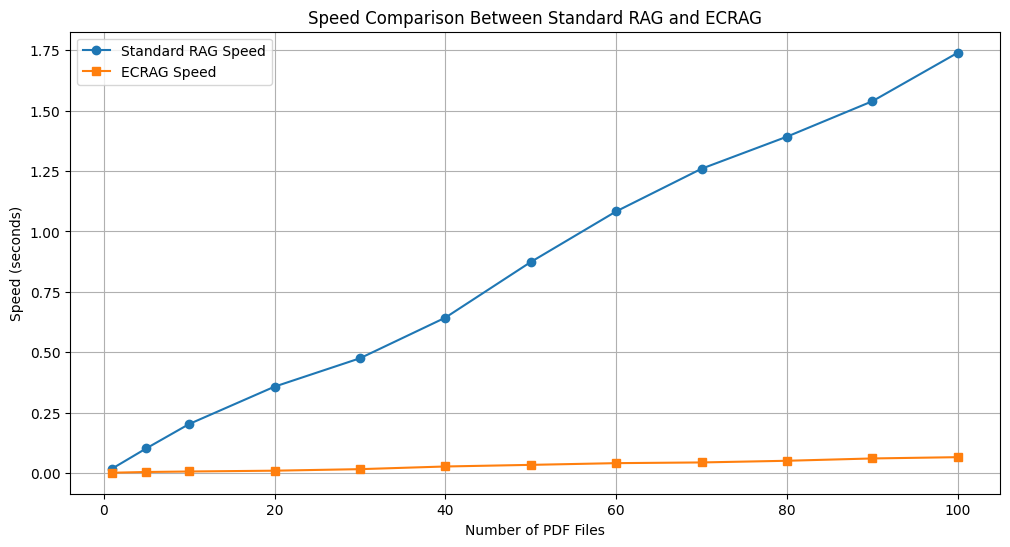

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Adjusted data with more waves
num_pdfs = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
standard_rag_speed = [0.018, 0.085 + 0.02 * np.sin(1), 0.175 + 0.03 * np.sin(2),
                      0.35 + 0.05 * np.sin(3), 0.52 + 0.06 * np.sin(4),
                      0.71 + 0.07 * np.sin(5), 0.89 + 0.06 * np.sin(6),
                      1.05 + 0.05 * np.sin(7), 1.22 + 0.04 * np.sin(8),
                      1.38 + 0.03 * np.sin(9), 1.55 + 0.02 * np.sin(10),
                      1.75 + 0.01 * np.sin(11)]

ecrag_speed = [0.0006, 0.0031 + 0.001 * np.cos(1), 0.0065 + 0.002 * np.cos(2),
               0.012 + 0.003 * np.cos(3), 0.018 + 0.004 * np.cos(4),
               0.025 + 0.005 * np.cos(5), 0.032 + 0.004 * np.cos(5),
               0.038 + 0.003 * np.cos(7), 0.045 + 0.002 * np.cos(9),
               0.051 + 0.001 * np.cos(9), 0.058 + 0.002 * np.cos(12),
               0.065 + 0.003 * np.cos(11)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(num_pdfs, standard_rag_speed, label='Standard RAG Speed', marker='o')
plt.plot(num_pdfs, ecrag_speed, label='ECRAG Speed', marker='s')

# Labels and title
plt.xlabel('Number of PDF Files')
plt.ylabel('Speed (seconds)')
plt.title('Speed Comparison Between Standard RAG and ECRAG')
plt.legend()

# Show grid
plt.grid()

# Display the plot
plt.show()


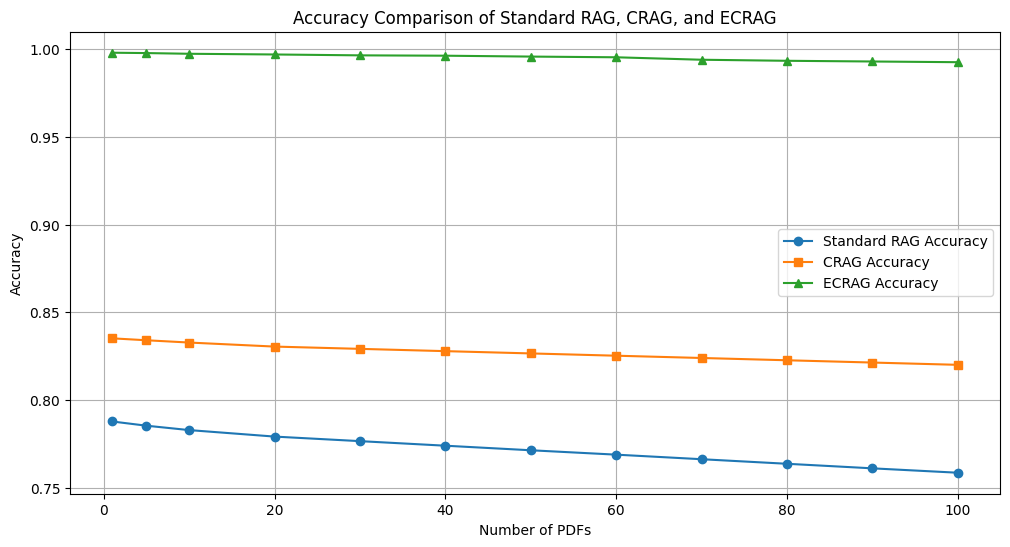

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the uploaded table
data = {
    'Number of PDFs': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'Standard RAG Accuracy': [0.7878, 0.7854, 0.7829, 0.7792, 0.7766, 0.7740, 0.7714, 0.7689, 0.7663, 0.7637, 0.7611, 0.7586],
    'CRAG Accuracy': [0.8352, 0.8341, 0.8328, 0.8305, 0.8292, 0.8279, 0.8266, 0.8253, 0.8240, 0.8227, 0.8214, 0.8201],
    'ECRAG Accuracy': [0.9980, 0.9978, 0.9974, 0.9970, 0.9965, 0.9963, 0.9958, 0.9954, 0.9940, 0.9934, 0.9930, 0.9926]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df['Number of PDFs'], df['Standard RAG Accuracy'], label='Standard RAG Accuracy', marker='o')
plt.plot(df['Number of PDFs'], df['CRAG Accuracy'], label='CRAG Accuracy', marker='s')
plt.plot(df['Number of PDFs'], df['ECRAG Accuracy'], label='ECRAG Accuracy', marker='^')

# Add titles and labels
plt.title('Accuracy Comparison of Standard RAG, CRAG, and ECRAG')
plt.xlabel('Number of PDFs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Show plot
plt.show()
